
Downloading the dataset from github leaf repository

In [1]:
!git clone https://github.com/TalwalkarLab/leaf.git
%cd leaf
# In leaf/data/shakespeare/preprocess/get_data.sh we should change the link
# to http://www.gutenberg.org/files/100/old/old/1994-01-100.zip and save that script

Cloning into 'leaf'...
remote: Enumerating objects: 782, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 782 (delta 1), reused 2 (delta 0), pack-reused 776 (from 1)
Receiving objects: 100% (782/782), 6.78 MiB | 12.02 MiB/s, done.
Resolving deltas: 100% (372/372), done.
/content/leaf


In [3]:
!pip install -r requirements.txt
%cd data/shakespeare
!./preprocess.sh --sf 0.2 -t sample -tf 0.8
%cd ../..

  Using cached numpy-1.16.4.zip (5.1 MB)
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement tensorflow==1.13.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==1.13.1
/content/leaf/data/shakespeare
--2025-01-15 15:42:00--  http://www.gutenberg.org/files/100/old/old/1994-01-100.zip
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gute


Dataset Tokenization

In [4]:
ALL_LETTERS = "\n !\"&'(),-.0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz}"
NUM_LETTERS = len(ALL_LETTERS)
print(NUM_LETTERS)

def _one_hot(index, size): # this function returns one-hot vector with given size and value 1 at given index
    vec = [0 for _ in range(size)]
    vec[int(index)] = 1
    return vec

def letter_to_vec(letter): # this function returns one-hot representation of given letter
    index = ALL_LETTERS.find(letter)
    return _one_hot(index, NUM_LETTERS)

def word_to_indices(word): # this function returns indices of given word
    indices = []
    for c in word:
        indices.append(ALL_LETTERS.find(c))
    return indices

80


Dataset Preprocessing

In [5]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
import os

# Function to read and parse training and testing data
def read_data(train_data_path, test_data_path):
    def read_file(path):
        with open(path, 'r') as f:
            return json.load(f)

    train_data = read_file(train_data_path)
    test_data = read_file(test_data_path)

    # Extract users and their corresponding data from training and testing datasets
    train_clients = list(train_data['users'])  # List of training users
    train_groups = list(train_data['user_data'].keys())  # Groups for training data
    train_data_temp = train_data['user_data']  # Actual training data

    test_clients = list(test_data['users'])  # List of testing users
    test_groups = list(test_data['user_data'].keys())  # Groups for testing data
    test_data_temp = test_data['user_data']  # Actual testing data

    return train_clients, train_groups, train_data_temp, test_data_temp

# Custom Dataset class for the Shakespeare dataset
class Shakespeare(Dataset):
    def __init__(self, train=True, args=None):
        super(Shakespeare, self).__init__()

        # Read the training and testing data
        train_clients, train_groups, train_data_temp, test_data_temp = read_data(args.shakespeare_train_path, args.shakespeare_test_path)
        self.train = train

        if self.train:
            # For training, organize data into inputs and labels
            self.dic_users = {}
            train_data_x = []
            train_data_y = []
            for i, client in enumerate(train_clients):
                self.dic_users[i] = set()
                l = len(train_data_x)
                cur_x = train_data_temp[client]['x']
                cur_y = train_data_temp[client]['y']
                for j in range(len(cur_x)):
                    self.dic_users[i].add(j + l)
                    train_data_x.append(cur_x[j])
                    train_data_y.append(cur_y[j])
            self.data = train_data_x
            self.label = train_data_y
        else:
            # For testing, organize data without user mapping
            test_data_x = []
            test_data_y = []
            for i, client in enumerate(train_clients):
                cur_x = test_data_temp[client]['x']
                cur_y = test_data_temp[client]['y']
                for j in range(len(cur_x)):
                    test_data_x.append(cur_x[j])
                    test_data_y.append(cur_y[j])
            self.data = test_data_x
            self.label = test_data_y

    def __len__(self):
        return len(self.data)

    # Fetches a single sample from the dataset by index.
    def __getitem__(self, index):
        sentence, target = self.data[index], self.label[index]
        indices = word_to_indices(sentence)
        target = letter_to_vec(target)
        indices = torch.LongTensor(np.array(indices))
        target = torch.FloatTensor(np.array(target))
        return indices, target

    # Returns the mapping of user IDs to their data indices.
    def get_client_dic(self):
        if self.train:
            return self.dic_users
        else:
            raise ValueError("The test dataset does not have dic_users!")

Defining the model and parameters

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader

class CharLSTM(nn.Module):
    def __init__(self):
        super(CharLSTM, self).__init__()
        embedding_dim = 8
        hidden_size = 100
        num_LSTM = 2
        input_length = 80
        self.n_cls = 80
        self.embedding = nn.Embedding(input_length, embedding_dim)
        self.stacked_LSTM = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_LSTM)
        self.fc = nn.Linear(hidden_size, self.n_cls)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        output, (h_, c_) = self.stacked_LSTM(x)
        last_hidden = output[-1, :, :]
        x = self.fc(last_hidden)

        return x

# Define the model, loss function, number of epochs, and optimizer
model = CharLSTM()
criterion = nn.CrossEntropyLoss()
epochs = 10
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

class Args:
    shakespeare_train_path = '/content/leaf/data/shakespeare/data/train/all_data_train_9.json'
    shakespeare_test_path = '/content/leaf/data/shakespeare/data/test/all_data_test_9.json'

args = Args()
train_dataset = Shakespeare(train=True, args=args)
test_dataset = Shakespeare(train=False, args=args)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Training and plot

In [11]:
import matplotlib.pyplot as plt

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # Reset gradients for the optimizer
        output = model(data) # Forward pass: Get predictions from the model
        loss = criterion(output, target) # Compute the loss between predictions and targets
        loss.backward() # Backward pass: Compute gradients of the loss with respect to model parameters
        optimizer.step() # Perform optimization step to update weights
        running_loss += loss.item() # Accumulate loss for reporting

        if batch_idx % 100 == 99:
            running_loss = 0.0  # Reset running loss

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    # Disable gradient calculations for evaluation to save memory and speed up computation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) # Forward pass: Get predictions from the model

            # Compute loss
            loss = criterion(output, target)
            test_loss += loss.item()

            # Find the class with the highest predicted score
            _, predicted = torch.max(output, 1)
            _, target_idx = torch.max(target, 1)

            # Update counts for accuracy calculation
            total += target.size(0)
            correct += (predicted == target_idx).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / total
    print(f'Test Loss: {test_loss:.6f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)')

    return test_loss, accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize lists to store test loss and accuracy
test_losses = []
test_accuracies = []

# Training settings
epochs = 25

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')
    train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = test(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

# Plot test loss
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.legend()
plt.savefig('test_loss_plot.pdf')
plt.close()

# Plot test accuracy
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.savefig('test_accuracy_plot.pdf')
plt.close()

Epoch 1/25
Test Loss: 0.025841, Accuracy: 183341/356921 (51.37%)
Epoch 2/25
Test Loss: 0.024705, Accuracy: 189922/356921 (53.21%)
Epoch 3/25
Test Loss: 0.024190, Accuracy: 192183/356921 (53.84%)
Epoch 4/25
Test Loss: 0.024050, Accuracy: 192498/356921 (53.93%)
Epoch 5/25
Test Loss: 0.023757, Accuracy: 194684/356921 (54.55%)
Epoch 6/25
Test Loss: 0.023704, Accuracy: 194775/356921 (54.57%)
Epoch 7/25
Test Loss: 0.023490, Accuracy: 195364/356921 (54.74%)
Epoch 8/25
Test Loss: 0.023414, Accuracy: 196500/356921 (55.05%)
Epoch 9/25
Test Loss: 0.023426, Accuracy: 195913/356921 (54.89%)
Epoch 10/25
Test Loss: 0.023380, Accuracy: 196051/356921 (54.93%)
Epoch 11/25
Test Loss: 0.023157, Accuracy: 197526/356921 (55.34%)
Epoch 12/25
Test Loss: 0.023144, Accuracy: 197849/356921 (55.43%)
Epoch 13/25
Test Loss: 0.023165, Accuracy: 198028/356921 (55.48%)
Epoch 14/25
Test Loss: 0.023044, Accuracy: 198229/356921 (55.54%)
Epoch 15/25
Test Loss: 0.023093, Accuracy: 198280/356921 (55.55%)
Epoch 16/25
Test Lo

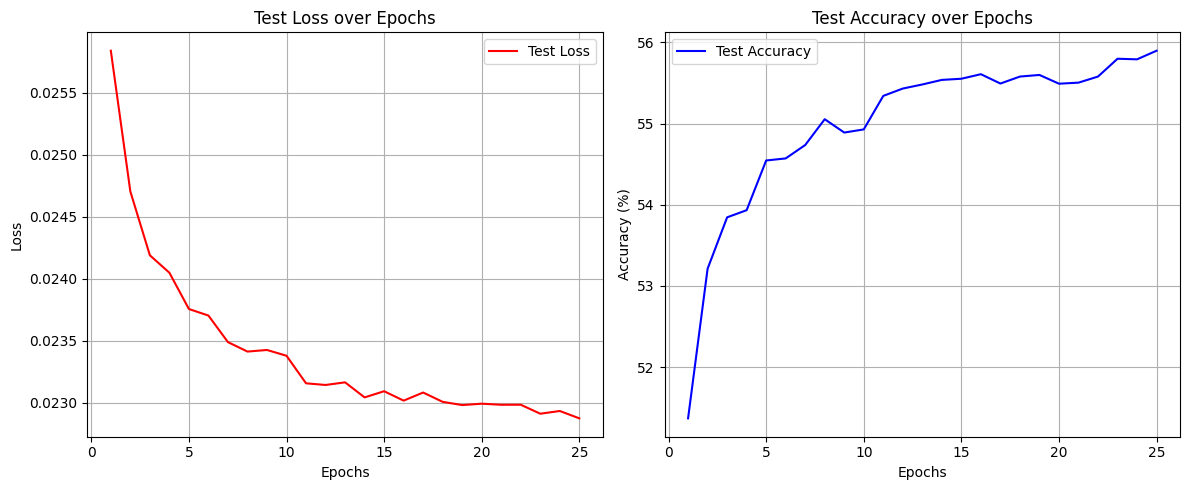

In [12]:
# Plotting the Test Loss and Accuracy
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Test Loss
plt.subplot(1, 2, 1)  # Create a subplot for test loss
plt.plot(epochs_range, test_losses, label='Test Loss', color='red')
plt.title('Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)  # Create a subplot for test accuracy
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', color='blue')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [14]:
epochs = 10

# Define a function for model training and testing
def train_and_test(model, train_loader, test_loader, criterion, optimizer, device):
    model.to(device)
    test_losses = []
    test_accuracies = []

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}')
        train(model, train_loader, criterion, optimizer, device)
        test_loss, accuracy = test(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

    return test_losses, test_accuracies

# Define hyperparameters and ranges for LR and WD
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0.0001, 0.001, 0.01]

best_lr = None
best_wd = None
best_accuracy = 0.0

# Iterate over all combinations of LR and WD
for lr in learning_rates:
    for wd in weight_decays:
        # Define your model, optimizer, and criterion
        model = CharLSTM()  # Replace YourModel with your actual model class
        optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr, weight_decay=wd)
        criterion = nn.CrossEntropyLoss()

        # Train and test the model
        test_losses, test_accuracies = train_and_test(model, train_loader, test_loader, criterion, optimizer, device)

        # Get the final accuracy
        final_accuracy = test_accuracies[-1]

        # Check if this combination gives the best accuracy so far
        if final_accuracy > best_accuracy:
            best_lr = lr
            best_wd = wd
            best_accuracy = final_accuracy

# Print the best LR, WD, and accuracy
print(f'Best LR: {best_lr}, Best WD: {best_wd}, Best Accuracy: {best_accuracy:.2f}%')

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import os

# Assuming CharLSTM and other dependencies are already defined (such as train/test functions)

# Directory to save checkpoints
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to save a checkpoint
def save_checkpoint(epoch, model, optimizer, test_losses, test_accuracies, best_lr, best_wd, best_accuracy, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'best_lr': best_lr,
        'best_wd': best_wd,
        'best_accuracy': best_accuracy,
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at {filepath}")

# Function to load a checkpoint
def load_checkpoint(filepath, model, optimizer):
    if os.path.exists(filepath):
        print(f"Loading checkpoint from {filepath}")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        test_losses = checkpoint['test_losses']
        test_accuracies = checkpoint['test_accuracies']
        best_lr = checkpoint['best_lr']
        best_wd = checkpoint['best_wd']
        best_accuracy = checkpoint['best_accuracy']
        return epoch, test_losses, test_accuracies, best_lr, best_wd, best_accuracy
    else:
        print(f"No checkpoint found at {filepath}")
        return 0, [], [], None, None, 0.0

# Function to train and test
def train_and_test(model, train_loader, test_loader, criterion, optimizer, device, start_epoch, epochs, checkpoint_path):
    test_losses = []
    test_accuracies = []

    for epoch in range(start_epoch + 1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")

        # Train and test for this epoch
        train(model, train_loader, criterion, optimizer, device)
        test_loss, accuracy = test(model, test_loader, criterion, device)

        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        # Save a checkpoint after every epoch
        save_checkpoint(
            epoch=epoch,
            model=model,
            optimizer=optimizer,
            test_losses=test_losses,
            test_accuracies=test_accuracies,
            best_lr=optimizer.param_groups[0]['lr'],
            best_wd=optimizer.param_groups[0]['weight_decay'],
            best_accuracy=max(test_accuracies),
            filepath=checkpoint_path
        )

    return test_losses, test_accuracies

# Hyperparameters and configurations
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0.0001, 0.001, 0.01]
epochs = 10

# Initialize best parameters
best_lr = None
best_wd = None
best_accuracy = 0.0

# Iterate over combinations of learning rates and weight decays
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for lr in learning_rates:
    for wd in weight_decays:
        print(f"\nTraining with LR={lr}, WD={wd}")

        # Initialize model, optimizer, and criterion
        model = CharLSTM()
        optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr, weight_decay=wd)
        criterion = nn.CrossEntropyLoss()

        # Path for saving checkpoints for this configuration
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_lr_{lr}_wd_{wd}.pth")

        # Load checkpoint if available
        start_epoch, test_losses, test_accuracies, best_lr_ckpt, best_wd_ckpt, best_accuracy_ckpt = load_checkpoint(
            checkpoint_path, model, optimizer
        )

        # Resume training or start fresh
        final_losses, final_accuracies = train_and_test(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            start_epoch=start_epoch,
            epochs=epochs,
            checkpoint_path=checkpoint_path
        )

        # Update best parameters based on final accuracy
        if final_accuracies[-1] > best_accuracy:
            best_lr = lr
            best_wd = wd
            best_accuracy = final_accuracies[-1]

# Print the best results
print(f"\nBest LR: {best_lr}, Best WD: {best_wd}, Best Accuracy: {best_accuracy:.2f}%")


In [ ]:
import matplotlib.pyplot as plt


# Initialize lists to store test loss and accuracy
test_losses = []
test_accuracies = []

# Training settings

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')
    train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = test(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

# Plot test loss
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.legend()
plt.savefig('test_loss_plot.pdf')
plt.close()

# Plot test accuracy
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.savefig('test_accuracy_plot.pdf')
plt.close()